**Data Pipeline pulling the 18th SDS Data from the Rest API**

In [ ]:
# Multi-year script to pull data from the Unified Data Library (UDL)
# for years 2022, 2023, 2024, and 2025 into separate DataFrames

import requests
import base64
import pandas as pd
import urllib3
from datetime import datetime

# Suppress SSL warnings (only for development - fix SSL in production)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# SET YOUR CREDENTIALS HERE
USERNAME = "adeola.adeyemi"  # Replace with your actual username
PASSWORD = "AstroCoderAde12$"  # Replace with your actual password

# Global variables to store each year's data
satellite_data_2022 = None
satellite_data_2023 = None
satellite_data_2024 = None
satellite_data_2025 = None

def get_udl_auth():
    """Get UDL authentication credentials from variables."""
    print("Setting up authentication...")

    if USERNAME and PASSWORD and PASSWORD != "your_password_here":
        print("Using username/password authentication")
        credentials = f"{USERNAME}:{PASSWORD}"
        encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('ascii')
        return f"Basic {encoded_credentials}"

    if 'BASE64_TOKEN' in globals():
        print("Using base64 token authentication")
        return f"Basic {BASE64_TOKEN}"

    print("ERROR: Please set your credentials at the top of the script!")
    return None

def fetch_udl_data(url, auth_header, year):
    """Fetch data from UDL API with error handling."""
    headers = {
        'Authorization': auth_header,
        'Accept': 'application/json',
        'User-Agent': 'UDL-Python-Client/1.0'
    }

    try:
        print(f"Making API request for {year}...")
        response = requests.get(url, headers=headers, verify=False, timeout=30)

        print(f"Response status for {year}: {response.status_code}")

        if response.status_code == 200:
            return response.json()
        else:
            print(f"API request failed for {year} with status code: {response.status_code}")
            print(f"Response content: {response.text}")
            return None

    except requests.exceptions.ConnectionError:
        print(f"Connection error for {year}. Check your internet connection and the URL.")
        return None
    except requests.exceptions.Timeout:
        print(f"Request timed out for {year}. The server may be slow or unresponsive.")
        return None
    except requests.exceptions.JSONDecodeError as e:
        print(f"Error decoding JSON response for {year}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error for {year}: {e}")
        return None

def process_year_data(data, year):
    """Process data for a specific year into DataFrame."""
    if data is None:
        print(f"No data received for {year}")
        return None

    print(f"Successfully retrieved {len(data)} records for {year}")

    try:
        df = pd.DataFrame(data)
        print(f"Data for {year} successfully converted to DataFrame")
        print(f"DataFrame shape for {year}: {df.shape}")

        # Add year column for identification
        df['data_year'] = year

        return df

    except Exception as e:
        print(f"Error processing data for {year} into DataFrame: {e}")
        return None

def analyze_year_data(df, year):
    """Perform exploratory analysis on a year's data."""
    if df is None:
        print(f"No data available for {year}")
        return

    print(f"\n=== ANALYSIS FOR {year} ===")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024:.2f} KB")

    # Check for missing values
    missing_data = df.isnull().sum()
    missing_count = missing_data.sum()
    if missing_count > 0:
        print(f"Missing values: {missing_count}")
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"  - {col}: {missing}")
    else:
        print("No missing values found!")

    # Time range if epoch exists
    if 'epoch' in df.columns:
        try:
            df_temp = df.copy()
            df_temp['epoch_datetime'] = pd.to_datetime(df_temp['epoch'])
            print(f"Date range: {df_temp['epoch_datetime'].min()} to {df_temp['epoch_datetime'].max()}")
            print(f"Time span: {(df_temp['epoch_datetime'].max() - df_temp['epoch_datetime'].min()).days} days")
        except:
            print("Could not parse epoch as datetime")

def fetch_all_years():
    """Fetch data for all years (2022, 2023, 2024, 2025)."""
    global satellite_data_2022, satellite_data_2023, satellite_data_2024, satellite_data_2025

    print("=== MULTI-YEAR UDL DATA RETRIEVAL STARTED ===")

    # Get authentication
    basic_auth = get_udl_auth()
    if not basic_auth:
        print("Authentication setup failed. Exiting.")
        return False

    # Define years and their corresponding URLs
    years_config = {
        2022: "https://unifieddatalibrary.com/udl/elset/history?epoch=2022-01-01T00:00:00.000000Z..2022-12-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS",
        2023: "https://unifieddatalibrary.com/udl/elset/history?epoch=2023-01-01T00:00:00.000000Z..2023-12-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS",
        2024: "https://unifieddatalibrary.com/udl/elset/history?epoch=2024-01-01T00:00:00.000000Z..2024-12-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS",
        2025: "https://unifieddatalibrary.com/udl/elset/history?epoch=2025-01-01T00:00:00.000000Z..2025-08-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS"  # Up to current date
    }

    results = {}

    # Fetch data for each year
    for year, url in years_config.items():
        print(f"\n{'='*50}")
        print(f"PROCESSING YEAR: {year}")
        print(f"URL: {url}")
        print(f"{'='*50}")

        # Fetch data
        data = fetch_udl_data(url, basic_auth, year)

        # Process data
        df = process_year_data(data, year)

        # Store in global variables
        if df is not None:
            if year == 2022:
                satellite_data_2022 = df
            elif year == 2023:
                satellite_data_2023 = df
            elif year == 2024:
                satellite_data_2024 = df
            elif year == 2025:
                satellite_data_2025 = df

            results[year] = df
            analyze_year_data(df, year)
        else:
            results[year] = None
            print(f"Failed to process data for {year}")

    return results

def compare_years():
    """Compare data across all years."""
    print(f"\n{'='*60}")
    print("MULTI-YEAR COMPARISON SUMMARY")
    print(f"{'='*60}")

    dataframes = {
        2022: satellite_data_2022,
        2023: satellite_data_2023,
        2024: satellite_data_2024,
        2025: satellite_data_2025
    }

    # Summary table
    print(f"{'Year':<8} {'Records':<10} {'Columns':<10} {'Memory (KB)':<12} {'Status'}")
    print("-" * 50)

    total_records = 0
    successful_years = 0

    for year, df in dataframes.items():
        if df is not None:
            records = len(df)
            columns = len(df.columns)
            memory = df.memory_usage().sum() / 1024
            status = "✅ Success"
            total_records += records
            successful_years += 1
        else:
            records = 0
            columns = 0
            memory = 0
            status = "❌ Failed"

        print(f"{year:<8} {records:<10} {columns:<10} {memory:<12.1f} {status}")

    print("-" * 50)
    print(f"{'TOTAL':<8} {total_records:<10} {'-':<10} {'-':<12} {successful_years}/4 years")

    # Check for common columns across successful years
    successful_dfs = [df for df in dataframes.values() if df is not None]
    if len(successful_dfs) > 1:
        common_cols = set(successful_dfs[0].columns)
        for df in successful_dfs[1:]:
            common_cols = common_cols.intersection(set(df.columns))

        print(f"\nCommon columns across all successful years: {len(common_cols)}")
        if len(common_cols) < 20:  # Only show if not too many
            print(f"Common columns: {sorted(list(common_cols))}")

def get_combined_data():
    """Combine all years into a single DataFrame."""
    print("Creating combined dataset...")

    dataframes = []
    for year, df in [(2022, satellite_data_2022), (2023, satellite_data_2023),
                     (2024, satellite_data_2024), (2025, satellite_data_2025)]:
        if df is not None:
            dataframes.append(df)
            print(f"Added {year}: {len(df)} records")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True, sort=False)
        print(f"Combined dataset created: {len(combined_df)} total records")
        return combined_df
    else:
        print("No data available to combine")
        return None

def main():
    """Main function to orchestrate multi-year data retrieval."""
    print("Starting multi-year UDL data retrieval...")

    # Fetch all years
    results = fetch_all_years()

    if not results:
        print("Failed to fetch any data. Exiting.")
        return

    # Display comparison
    compare_years()

    # Success summary
    successful_years = [year for year, df in results.items() if df is not None]
    failed_years = [year for year, df in results.items() if df is None]

    print(f"\n{'='*60}")
    print("FINAL SUMMARY")
    print(f"{'='*60}")
    print(f"✅ Successfully loaded: {len(successful_years)} years")
    if successful_years:
        print(f"   Years: {successful_years}")

    if failed_years:
        print(f"❌ Failed to load: {len(failed_years)} years")
        print(f"   Years: {failed_years}")

    print(f"\n📊 AVAILABLE DATAFRAMES:")
    if satellite_data_2022 is not None:
        print(f"   satellite_data_2022: {satellite_data_2022.shape}")
    if satellite_data_2023 is not None:
        print(f"   satellite_data_2023: {satellite_data_2023.shape}")
    if satellite_data_2024 is not None:
        print(f"   satellite_data_2024: {satellite_data_2024.shape}")
    if satellite_data_2025 is not None:
        print(f"   satellite_data_2025: {satellite_data_2025.shape}")

    print(f"\n🔗 ADDITIONAL FUNCTIONS AVAILABLE:")
    print(f"   compare_years()      # Compare data across years")
    print(f"   get_combined_data()  # Combine all years into one DataFrame")

    return results

if __name__ == "__main__":
    print("Multi-Year UDL Data Retrieval Script")
    print("====================================")
    results = main()

    if results:
        print(f"\n🚀 Ready for multi-year satellite data analysis!")
        print(f"   Each year's data is stored in separate DataFrames")
        print(f"   Use the comparison and analysis functions for insights")
    else:
        print(f"\n❌ Script completed with errors")

    print("\n" + "="*60)

Multi-Year UDL Data Retrieval Script
Starting multi-year UDL data retrieval...
=== MULTI-YEAR UDL DATA RETRIEVAL STARTED ===
Setting up authentication...
Using username/password authentication

PROCESSING YEAR: 2022
URL: https://unifieddatalibrary.com/udl/elset/history?epoch=2022-01-01T00:00:00.000000Z..2022-12-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS
Making API request for 2022...
Response status for 2022: 200
Successfully retrieved 30000 records for 2022
Data for 2022 successfully converted to DataFrame
DataFrame shape for 2022: (30000, 27)

=== ANALYSIS FOR 2022 ===
Shape: (30000, 28)
Memory usage: 6562.63 KB
No missing values found!
Date range: 2022-09-09 22:49:01.376832+00:00 to 2022-09-10 16:55:51.995424+00:00
Time span: 0 days

PROCESSING YEAR: 2023
URL: https://unifieddatalibrary.com/udl/elset/history?epoch=2023-01-01T00:00:00.000000Z..2023-12-31T00:00:00.000000Z&dataMode=REAL&source=18th%20SPCS
Making API request for 2023...
Response status for 2023: 200
Successful

## **Exporting the files to CSV by years**

In [ ]:
satellite_data_2025.to_csv('satellite_data_2025.csv')
satellite_data_2024.to_csv('satellite_data_2024.csv')
satellite_data_2023.to_csv('satellite_data_2023.csv')
satellite_data_2022.to_csv('satellite_data_2022.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


UPLOAD CSV FILE - COMBINED DATASET WITH SOME CALCULATED COLUMNS USING POWER QUERY.


In [ ]:
import pandas as pd

df2025 = pd.read_csv('satellite_data_2025.csv')
df2024 = pd.read_csv('satellite_data_2024.csv')
df2023 = pd.read_csv('satellite_data_2023.csv')
df2022 = pd.read_csv('satellite_data_2022.csv')

In [ ]:
combined_df = pd.concat([df2025, df2024, df2023, df2022], ignore_index=True)

In [ ]:
combined_df.to_csv('satellite_data_combined.csv', index=False)

In [ ]:
df2025.head(2)

,Unnamed: 0,argOfPerigee,apogee,idOnOrbit,meanMotionDDot,epoch,source,origNetwork,perigee,semiMajorAxis,...,raan,revNo,dataMode,meanMotionDot,createdBy,meanAnomaly,line1,line2,satNo,data_year
0,0,158.6033,6948.723,38358,0.0,2025-01-01T00:00:00.999648Z,18th SPCS,OPS1,6936.538,6942.631,...,43.504,130,REAL,0.000094,system.ob-ingest,263.417,1 38358U 12031A 25001.00001157 +.00009434 +0...,2 38358 6.0281 43.5040 0008775 158.6033 263...,38358,2025
1,1,118.2583,6875.269,44720,0.0,2025-01-01T00:00:00.999648Z,18th SPCS,OPS1,6869.029,6872.149,...,315.367,544,REAL,0.001066,system.ob-ingest,134.500,1 44720U 19074H 25001.00001157 +.00106642 +0...,2 44720 53.0564 315.3670 0004540 118.2583 134...,44720,2025


**INSTALL PACKAGES FOR PROPAGATION**


In [ ]:
!pip install pandas numpy sgp4
#pandas for tables
#numpy for maths opeartions
#sgp4 to propagate TLEs to positions (ECI frame)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 8.9 MB/s eta 0:00:00


LOAD CSV IN COLAB

In [ ]:
import pandas as pd
df = pd.read_csv('satellite_data_combined.csv', parse_dates=['epoch'])
df.head(2)

,Unnamed: 0,argOfPerigee,apogee,idOnOrbit,meanMotionDDot,epoch,source,origNetwork,perigee,semiMajorAxis,...,raan,revNo,dataMode,meanMotionDot,createdBy,meanAnomaly,line1,line2,satNo,data_year
0,0,158.6033,6948.723,38358,0.0,2025-01-01 00:00:00.999648+00:00,18th SPCS,OPS1,6936.538,6942.631,...,43.504,130,REAL,0.000094,system.ob-ingest,263.417,1 38358U 12031A 25001.00001157 +.00009434 +0...,2 38358 6.0281 43.5040 0008775 158.6033 263...,38358,2025
1,1,118.2583,6875.269,44720,0.0,2025-01-01 00:00:00.999648+00:00,18th SPCS,OPS1,6869.029,6872.149,...,315.367,544,REAL,0.001066,system.ob-ingest,134.500,1 44720U 19074H 25001.00001157 +.00106642 +0...,2 44720 53.0564 315.3670 0004540 118.2583 134...,44720,2025


PROPAGATE TLEs TO POSITIONS - CALCULATE SATELLITE POSITIONS


In [ ]:
from sgp4.api import Satrec, jday
import numpy as np

# Prepare a list to store results
results = []

for idx, row in df.iterrows():
    sat = Satrec.twoline2rv(row['line1'], row['line2'])

    ts = row['epoch'].to_pydatetime()

    # Convert to Julian date
    jd, fr = jday(ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second + ts.microsecond/1e6)

    error_code, r, v = sat.sgp4(jd, fr)

    if error_code == 0:
        x, y, z = r        # km
        vx, vy, vz = v     # km/s
        results.append({
            'satNo': row['satNo'],
            'epoch': row['epoch'],
            'x_km': x, 'y_km': y, 'z_km': z,
            'vx_km_s': vx, 'vy_km_s': vy, 'vz_km_s': vz
        })
    else:
        # Handle TLE errors
        results.append({
            'satNo': row['satNo'],
            'epoch': row['epoch'],
            'x_km': np.nan, 'y_km': np.nan, 'z_km': np.nan,
            'vx_km_s': np.nan, 'vy_km_s': np.nan, 'vz_km_s': np.nan
        })

# Convert results to DataFrame
pos_df = pd.DataFrame(results)

# Quick check
pos_df.head()

,satNo,epoch,x_km,y_km,z_km,vx_km_s,vy_km_s,vz_km_s
0,38358,2025-01-01 00:00:00.999648+00:00,-1821.707068,6665.253607,642.512427,-7.295518,-2.037398,0.374556
1,44720,2025-01-01 00:00:00.999648+00:00,-4221.855293,-1385.344113,-5251.509673,4.221299,-6.065850,-1.797582
2,44732,2025-01-01 00:00:00.999648+00:00,-5271.757894,3315.018642,2918.944252,-4.744134,-2.987784,-5.155190
3,44733,2025-01-01 00:00:00.999648+00:00,-1856.593340,5712.153641,2981.853776,-5.712165,0.827775,-5.118879
4,44740,2025-01-01 00:00:00.999648+00:00,-4489.451535,-2526.038735,-4523.183945,5.618046,-3.834526,-3.437837


SAVE POSITIONS TO CSV

In [ ]:
from google.colab import files

pos_df.to_csv('satellite_positions.csv', index=False)
files.download('satellite_positions.csv')  # will download to your computer

DETECT POTENTIAL COLLISIONS (CONJUNCTION ANALYSIS)

In [ ]:
from itertools import combinations
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

# Set thresholds by orbit type (km) - These thresholds are not directly used for distance calculation
# but can be used for flagging or filtering later if orbit category is available in pos_df
thresholds = {
    'LEO': 1.0,
    'MEO': 5.0,
    'GEO': 10.0,
    'HEO': 10.0
}
default_threshold = 1.0 # This is the threshold used for flagging collision risk

# Function to perform conjunction analysis for a single epoch
def analyze_epoch_conjunctions(epoch_group):
    epoch, group = epoch_group
    epoch_results = []
    sats_at_epoch = group.set_index('satNo')
    sat_numbers = sats_at_epoch.index.tolist()

    for sat1_num, sat2_num in combinations(sat_numbers, 2):
        sat1_pos = sats_at_epoch.loc[sat1_num]
        sat2_pos = sats_at_epoch.loc[sat2_num]

        dist = np.linalg.norm([
            sat1_pos['x_km'] - sat2_pos['x_km'],
            sat1_pos['y_km'] - sat2_pos['y_km'],
            sat1_pos['z_km'] - sat2_pos['z_km']
        ])

        threshold = default_threshold
        collision_flag = dist < threshold

        # Find original orbital categories and launch years from the original df
        # (Assuming df is accessible in the worker process - for large df, consider passing relevant columns)
        sat1_orig = df[df['satNo'] == sat1_num].iloc[0]
        sat2_orig = df[df['satNo'] == sat2_num].iloc[0]

        epoch_results.append({
            'Epoch': epoch,
            'SatNo1': sat1_num,
            'SatNo2': sat2_num,
            'Distance_km': dist,
            'Collision_Risk_Flag': collision_flag,
            'Sat1_Orbit': sat1_orig.get('Orbit_Category', None),
            'Sat2_Orbit': sat2_orig.get('Orbit_Category', None),
            'Sat1_LaunchYear': sat1_orig.get('Designator_year_launch', None),
            'Sat2_LaunchYear': sat2_orig.get('Designator_year_launch', None)
        })
    return epoch_results

# Group satellites by Epoch in the pos_df DataFrame
grouped_epochs = pos_df.groupby('epoch')

# Use multiprocessing Pool to analyze epochs in parallel
# Number of processes to use (can adjust based on available cores)
num_processes = cpu_count()
print(f"Using {num_processes} processes for parallel processing.")

all_results = []
with Pool(num_processes) as pool:
    # pool.imap_unordered is used for potentially better memory usage with large iterables
    for epoch_results in pool.imap_unordered(analyze_epoch_conjunctions, grouped_epochs):
        all_results.extend(epoch_results)


# Convert results to DataFrame
conjunction_df = pd.DataFrame(all_results)

# Optional: filter only potential collisions
collision_only = conjunction_df[conjunction_df['Collision_Risk_Flag']]

# Save to CSV and download
conjunction_df.to_csv('conjunction_analysis.csv', index=False)
from google.colab import files
files.download('conjunction_analysis.csv')

Using 2 processes for parallel processing.


KeyboardInterrupt: 

## **BASIC RISK ASSESSMENT SYSTEM (Converts collision detections into actionable risk levels) By Vevina**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 📂 Load the Satellite Dataset

In [ ]:
import pandas as pd

# Input dataset path (already uploaded to Drive)
input_path = "/content/drive/MyDrive/satellite_data_combined.csv"

# Load the dataset
df = pd.read_csv(input_path)
print("Dataset shape:", df.shape)
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/satellite_data_combined.csv'

### 2. Define Thresholds (for Interpretability)

In [ ]:
# Thresholds stored in a dictionary for easy tuning
THRESHOLDS = {
    "critical_perigee": 500,
    "critical_revno": 6000,
    "high_perigee": 800,
    "high_revno": 4000,
    "medium_perigee": 1200,
    "medium_revno": 2000
}


### 3. Risk Function (Proxy: Perigee + RevNo)

In [ ]:
def proxy_risk(perigee, revNo, thresholds=THRESHOLDS):
    if perigee < thresholds["critical_perigee"] or revNo > thresholds["critical_revno"]:
        return "Critical"
    elif perigee < thresholds["high_perigee"] or revNo > thresholds["high_revno"]:
        return "High"
    elif perigee < thresholds["medium_perigee"] or revNo > thresholds["medium_revno"]:
        return "Medium"
    else:
        return "Low"

# Add risk levels
df['risk_level'] = df.apply(lambda row: proxy_risk(row['perigee'], row['revNo']), axis=1)


### 4.  Add Interpretability (Reason Codes)

In [ ]:
def explain_reason(perigee, revNo, thresholds=THRESHOLDS):
    if perigee < thresholds["critical_perigee"]:
        return f"Perigee below {thresholds['critical_perigee']} km"
    if revNo > thresholds["critical_revno"]:
        return f"RevNo above {thresholds['critical_revno']}"
    if perigee < thresholds["high_perigee"]:
        return f"Perigee between {thresholds['critical_perigee']}–{thresholds['high_perigee']} km"
    if revNo > thresholds["high_revno"]:
        return f"RevNo between {thresholds['high_revno']}–{thresholds['critical_revno']}"
    if perigee < thresholds["medium_perigee"]:
        return f"Perigee between {thresholds['high_perigee']}–{thresholds['medium_perigee']} km"
    if revNo > thresholds["medium_revno"]:
        return f"RevNo between {thresholds['medium_revno']}–{thresholds['high_revno']}"
    return "Safe orbit"

df['risk_reason'] = df.apply(lambda row: explain_reason(row['perigee'], row['revNo']), axis=1)


### 5.  Visualize Risk Levels

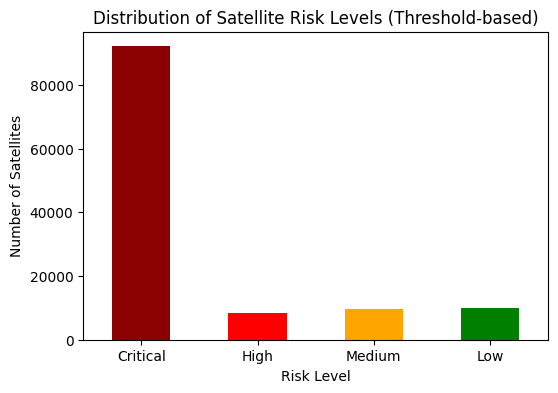

,count
risk_level,
Critical,92080
High,8328
Medium,9606
Low,9986


In [ ]:
import matplotlib.pyplot as plt

# Ensure all categories appear in correct order
risk_order = ["Critical", "High", "Medium", "Low"]
risk_counts = df['risk_level'].value_counts().reindex(risk_order, fill_value=0)

# Plot
plt.figure(figsize=(6,4))
risk_counts.plot(kind='bar', color=['darkred','red','orange','green'])
plt.title("Distribution of Satellite Risk Levels (Threshold-based)")
plt.xlabel("Risk Level")
plt.ylabel("Number of Satellites")
plt.xticks(rotation=0)
plt.show()

risk_counts


### 6. Save Risk Assessment Output

In [ ]:
output_path = "/content/drive/MyDrive/satellite_data_risk_assessment_v3.csv"
df.to_csv(output_path, index=False)
print("✅ Risk assessment saved to:", output_path)


✅ Risk assessment saved to: /content/drive/MyDrive/satellite_data_risk_assessment_v3.csv


### 7. Future-Ready Function (Collision Detection Data)

In [ ]:
def collision_risk(miss_distance_km, time_to_tca_hours):
    if miss_distance_km < 1 and time_to_tca_hours < 24:
        return "Critical"
    elif miss_distance_km < 5 and time_to_tca_hours < 72:
        return "High"
    elif miss_distance_km < 20:
        return "Medium"
    else:
        return "Low"


### **Real-Time Example: IRAS–GGSE-4 Close Approach** - **By Vevina**

In [ ]:
# Real-World Example: IRAS & GGSE-4 Conjunction

import pandas as pd
import matplotlib.pyplot as plt

# Real documented event: IRAS vs GGSE-4 close approach (Jan 2020)
real_event = pd.DataFrame({
    "satA": ["IRAS"],
    "satB": ["GGSE-4"],
    "miss_distance_km": [0.0063],    # ~63 meters
    "time_to_tca_hours": [24],       # 24 hours to conjunction
    "rel_speed_kms": [14.7]
})

# Collision risk function (future-ready)
def collision_risk(miss_distance_km, time_to_tca_hours):
    if miss_distance_km < 1 and time_to_tca_hours < 24:
        return "Critical"
    elif miss_distance_km < 5 and time_to_tca_hours < 72:
        return "High"
    elif miss_distance_km < 20:
        return "Medium"
    else:
        return "Low"

# Apply risk function
real_event['risk_level'] = real_event.apply(
    lambda row: collision_risk(row['miss_distance_km'], row['time_to_tca_hours']),
    axis=1
)

print("Real-time collision example assessment:")
display(real_event)


Real-time collision example assessment:


,satA,satB,miss_distance_km,time_to_tca_hours,rel_speed_kms,risk_level
0,IRAS,GGSE-4,0.0063,24,14.7,High


**Visualization of Risk Level**

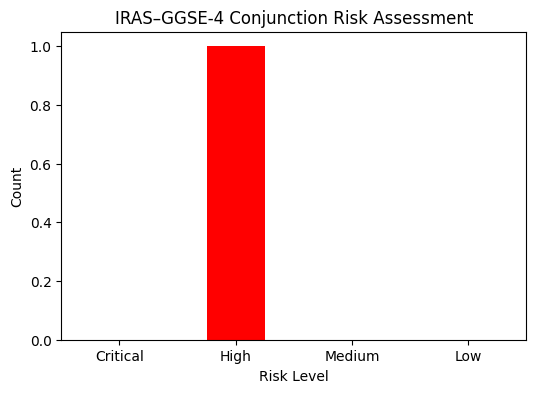

In [ ]:
# Visualization of the single-event classification
risk_counts = real_event['risk_level'].value_counts().reindex(
    ["Critical", "High", "Medium", "Low"], fill_value=0
)

plt.figure(figsize=(6,4))
risk_counts.plot(kind='bar', color=['darkred','red','orange','green'])
plt.title("IRAS–GGSE-4 Conjunction Risk Assessment")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


### AI- POWERED COLLISION PREDICTION by likhita

## import the libraries

In [ ]:
# Import the necessary libraries
import pandas as pd

# Load satellite position and metadata
physical_df = pd.read_csv('satellite_positions.csv')
metadata_df = pd.read_csv('satellite_data_combined.csv')

# Merge on 'satNo'
df = pd.merge(physical_df, metadata_df, on='satNo', how='inner')
# Save the merged dataset
df.to_csv("combined_dataset.csv", index=False)

## Load the dataset and drop the unnecessary columns and also combining the epoch_x and epoch_y as epoch then converting the epoch to date time format

In [ ]:
import pandas as pd

# Load merged dataset
df = pd.read_csv("combined_dataset.csv")

# Drop irrelevant columns
drop_cols = ['Unnamed: 0', 'line1', 'line2', 'createdAt', 'createdBy', 'source', 'origNetwork', 'data_year']
df = df.drop(columns=drop_cols, errors='ignore')

# Combine 'epoch_x' and 'epoch_y' into unified 'epoch'
df['epoch'] = df['epoch_x'].combine_first(df['epoch_y'])

# Convert to datetime format
df['epoch'] = pd.to_datetime(df['epoch'], errors='coerce')

# Drop duplicate rows
df = df.drop_duplicates()


In [ ]:
# Save cleaned dataset
df.to_csv("cleaned_combined_dataset.csv", index=False)

In [ ]:
df.columns

Index(['satNo', 'epoch_x', 'x_km', 'y_km', 'z_km', 'vx_km_s', 'vy_km_s',
       'vz_km_s', 'argOfPerigee', 'apogee', 'idOnOrbit', 'meanMotionDDot',
       'epoch_y', 'perigee', 'semiMajorAxis', 'idElset', 'bStar',
       'classificationMarking', 'algorithm', 'inclination', 'period',
       'meanMotion', 'eccentricity', 'raan', 'revNo', 'dataMode',
       'meanMotionDot', 'meanAnomaly', 'epoch'],
      dtype='object')

## Selecting the important features that are usefull for further prediction tasks and then drop the rows with NAN values

In [ ]:
# Define enriched feature set
enriched_features = [
    'x_km', 'y_km', 'z_km',
    'vx_km_s', 'vy_km_s', 'vz_km_s',
    'eccentricity', 'semiMajorAxis', 'perigee', 'apogee',
    'meanMotion', 'meanMotionDot', 'meanMotionDDot', 'period',
    'inclination', 'raan', 'argOfPerigee', 'meanAnomaly',
    'bStar'
]

# Drop rows with missing values in enriched features
df = df.dropna(subset=enriched_features)

## selected the isolation forest for the prediction task as this model is best suited for large dataset and also faster in training and testing.

In [ ]:
# Isolation forest model training

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[enriched_features])

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = model.fit_predict(X_scaled)
df['potential_collision'] = df['anomaly_score'] == -1
df['collision_label'] = df['anomaly_score'].map({1: 'Normal', -1: 'Anomalous'})

# Save model and scaler
joblib.dump(model, "enriched_collision_model.pkl")
joblib.dump(scaler, "enriched_scaler.pkl")


['enriched_scaler.pkl']

## satellites that is predited to have collisions.

In [ ]:
# Show satellites with predicted collisions
collision_satnos = df[df['potential_collision']]['satNo'].unique()
print("Satellites with predicted collisions (enriched model):")
for i, sat in enumerate(collision_satnos, start=1):
    print(f"{i} - Satellite {sat}")


Satellites with predicted collisions (enriched model):
1 - Satellite 25671
2 - Satellite 32396
3 - Satellite 25465
4 - Satellite 38690
5 - Satellite 24897
6 - Satellite 13080
7 - Satellite 20355
8 - Satellite 23229
9 - Satellite 22248
10 - Satellite 27039
11 - Satellite 43634
12 - Satellite 21803
13 - Satellite 42464
14 - Satellite 49337
15 - Satellite 44204
16 - Satellite 33276
17 - Satellite 37848
18 - Satellite 36517
19 - Satellite 45466
20 - Satellite 25667
21 - Satellite 23645
22 - Satellite 46826
23 - Satellite 43515
24 - Satellite 24720
25 - Satellite 15741
26 - Satellite 26808
27 - Satellite 3284
28 - Satellite 17328
29 - Satellite 27528
30 - Satellite 43564
31 - Satellite 43648
32 - Satellite 6974
33 - Satellite 59986
34 - Satellite 60086
35 - Satellite 39235
36 - Satellite 10061
37 - Satellite 10987
38 - Satellite 10669
39 - Satellite 49258
40 - Satellite 49048
41 - Satellite 59985
42 - Satellite 9009
43 - Satellite 38187
44 - Satellite 15158
45 - Satellite 28563
46 - Satelli

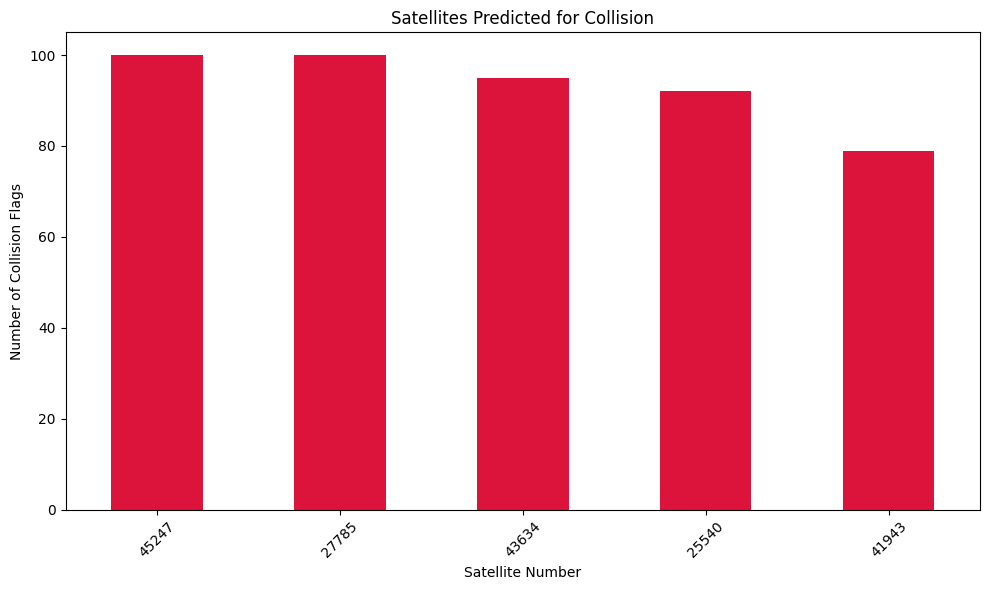

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each satellite
collision_counts = df[df['potential_collision']]['satNo'].value_counts().head(5)

# Plot bar chart
plt.figure(figsize=(10, 6))
collision_counts.plot(kind='bar', color='crimson')
plt.title('Satellites Predicted for Collision')
plt.xlabel('Satellite Number')
plt.ylabel('Number of Collision Flags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from datetime import datetime
import pytz

df['epoch'] = pd.to_datetime(df['epoch'], errors='coerce')

# Filter for satellite 36979
sat_id = 36979
sat_df = df[(df['satNo'] == sat_id) & (df['potential_collision'])]

# Current time in UTC
now = datetime.utcnow().replace(tzinfo=pytz.UTC)

if not sat_df.empty:
    collision_time = sat_df['epoch'].min()
    time_diff = collision_time - now
    collision_date = collision_time.strftime('%Y-%m-%d')

    if time_diff.total_seconds() < 0:
        print(f"ALERT: Satellite {sat_id} was predicted to collide on {collision_date} ({abs(time_diff.days)} days ago).")
    else:
        print(f"ALERT: Satellite {sat_id} is predicted to collide on {collision_date} (in {time_diff.days} days).")
else:
    print(f"No predicted collisions for Satellite {sat_id}.")

ALERT: Satellite 36979 was predicted to collide on 2022-09-09 (1101 days ago).


/tmp/ipython-input-438430658.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=pytz.UTC)


In [ ]:
import pandas as pd
from datetime import datetime
import pytz

# Filter only satellites flagged for potential collision
collision_df = df[df['potential_collision']]

# Current time in UTC
now = datetime.utcnow().replace(tzinfo=pytz.UTC)

# Group by satellite and get earliest collision time
alerts = []
for sat in collision_df['satNo'].unique():
    sat_data = collision_df[collision_df['satNo'] == sat]
    collision_time = sat_data['epoch'].min()

    if pd.notnull(collision_time):
        collision_time = collision_time.replace(tzinfo=pytz.UTC)
        time_diff = collision_time - now
        days = abs(time_diff.days)
        collision_date = collision_time.strftime('%Y-%m-%d')

        if time_diff.total_seconds() < 0:
            alerts.append(f"ALERT: Satellite {sat} was predicted to collide on {collision_date} ({days} days ago).")
        else:
            alerts.append(f"ALERT: Satellite {sat} is predicted to collide on {collision_date} (in {days} days).")

# Display all alerts
for alert in alerts:
    print(alert)


/tmp/ipython-input-2782227009.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=pytz.UTC)


ALERT: Satellite 25671 was predicted to collide on 2024-11-28 (290 days ago).
ALERT: Satellite 32396 was predicted to collide on 2023-01-01 (987 days ago).
ALERT: Satellite 25465 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 38690 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 24897 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 13080 was predicted to collide on 2024-11-28 (290 days ago).
ALERT: Satellite 20355 was predicted to collide on 2024-11-28 (290 days ago).
ALERT: Satellite 23229 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 22248 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 27039 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 43634 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 21803 was predicted to collide on 2022-09-10 (1100 days ago).
ALERT: Satellite 42464 was predicted to collide on 2022-

In [ ]:
# Select first two satellites with alerts
selected_sats = [int(alert.split()[2]) for alert in alerts[:2]]

# Filter data for those satellites
selected_df = collision_df[collision_df['satNo'].isin(selected_sats)].copy()
selected_df['epoch'] = pd.to_datetime(selected_df['epoch'])


In [ ]:
# Save the selected satellites' data to CSV
selected_df.to_csv("selected_satellites.csv", index=False)

# Download to your computer
from google.colab import files
files.download("selected_satellites.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import plotly.express as px

fig = px.scatter(
    selected_df,
    x='epoch',
    y='satNo',
    color='satNo',
    title='Predicted Collision Timeline for Two Satellites',
    labels={'epoch': 'Predicted Collision Time', 'satNo': 'Satellite Number'},
    hover_data=['epoch']
)

fig.update_traces(marker=dict(size=12))
fig.show()


In [ ]:
import plotly.express as px

# Format epoch for display
selected_df['Collision Time'] = selected_df['epoch'].dt.strftime('%Y-%m-%d %H:%M')

# Create scatter plot
fig = px.scatter(
    selected_df,
    x='epoch',
    y='satNo',
    color='satNo',
    title='Predicted Collision Timeline for Two Satellites',
    labels={'epoch': 'Predicted Collision Time', 'satNo': 'Satellite Number'},
    text='Collision Time'  # Show collision time as label
)

# Customize marker and label appearance
fig.update_traces(marker=dict(size=12), textposition='top center')
fig.update_layout(showlegend=True)
fig.show()


In [ ]:
# Choose one satellite (e.g., the first one from alerts)
single_sat = int(alerts[0].split()[2])  # Extract satellite number from first alert

# Filter data for that satellite only
single_df = selected_df[selected_df['satNo'] == single_sat].copy()

# Format epoch for display
single_df['Collision Time'] = single_df['epoch'].dt.strftime('%Y-%m-%d %H:%M')

# Create scatter plot with visible labels
import plotly.express as px

fig = px.scatter(
    single_df,
    x='epoch',
    y='satNo',
    color='satNo',
    title=f'Predicted Collision Timeline for Satellite {single_sat}',
    labels={'epoch': 'Predicted Collision Time', 'satNo': 'Satellite Number'},
    text='Collision Time'  # Show collision time as label
)

fig.update_traces(marker=dict(size=12), textposition='top center')
fig.update_layout(showlegend=False)
fig.show()


In [ ]:
import plotly.express as px
from datetime import datetime
import pytz
import pandas as pd

# Current time
now = datetime.utcnow().replace(tzinfo=pytz.UTC)

# Prepare bar chart data
bar_data = []
labels = ['Satellite A', 'Satellite B']  # You can expand this list if needed

for i, sat in enumerate(selected_sats[:2]):  # Limit to first two satellites
    sat_data = selected_df[selected_df['satNo'] == sat]
    collision_time = sat_data['epoch'].min()
    if pd.notnull(collision_time):
        time_diff = collision_time - now
        days = time_diff.days
        bar_data.append({
            'Satellite': sat,
            'Days Until Collision': days,
            'Label': labels[i]  # Assign custom label
        })

# Convert to DataFrame
bar_df = pd.DataFrame(bar_data)

# Plot bar chart using custom labels
fig = px.bar(
    bar_df,
    x='Label',
    y='Days Until Collision',
    color='Label',
    title='Time Remaining Until Predicted Collision',
    text='Days Until Collision',
    color_discrete_sequence=['crimson', 'darkorange']  # Optional custom colors
)

fig.update_traces(texttemplate='%{text} days', textposition='outside')
fig.update_layout(xaxis_title='Satellite', yaxis_title='Days Remaining')
fig.show()


/tmp/ipython-input-3022557232.py:7: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [ ]:
import plotly.express as px
from IPython.display import display, HTML

# Format collision time for display
single_df['Collision Time'] = single_df['epoch'].dt.strftime('%Y-%m-%d %H:%M')

# Create scatter plot
fig = px.scatter(
    single_df,
    x='epoch',
    y='satNo',
    color='satNo',
    title=f'Predicted Collision Timeline for Satellite {single_sat}',
    labels={'epoch': 'Predicted Collision Time', 'satNo': 'Satellite Number'}
)

fig.update_traces(marker=dict(size=12))
fig.update_layout(showlegend=False)
fig.show()

# Display collision time statements below the graph
statements = []
for _, row in single_df.iterrows():
    statements.append(f"Satellite {row['satNo']} is predicted to collide on {row['Collision Time']}.")

# Render as HTML paragraph
display(HTML("<br>".join(statements)))


In [ ]:
# Satellite predicted for collision that has already happened
# meaning lets say satno. 23865 - this satellite event for collision has happened
from datetime import datetime
import pytz

# Current time in UTC
now = datetime.utcnow().replace(tzinfo=pytz.UTC)

# List satellites with any predicted collision
collision_satnos = df[df['potential_collision']]['satNo'].unique()
print("These are the satellites listed for collision:")

for i, sat in enumerate(collision_satnos, start=1):
    sat_df = df[(df['satNo'] == sat) & (df['potential_collision'])]
    if not sat_df.empty:
        collision_time = sat_df['epoch'].min()
        time_diff = collision_time - now
        days = abs(time_diff.days)
        seconds = abs(time_diff.seconds)
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60

        if time_diff.total_seconds() < 0:
            print(f"{i} - Satellite {sat}: Collision predicted {days} days, {hours} hours, {minutes} minutes ago")
        else:
            print(f"{i} - Satellite {sat}: {days} days, {hours} hours, {minutes} minutes remaining")


/tmp/ipython-input-3415509770.py:7: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



These are the satellites listed for collision:
1 - Satellite 25671: Collision predicted 290 days, 9 hours, 3 minutes ago
2 - Satellite 32396: Collision predicted 987 days, 10 hours, 14 minutes ago
3 - Satellite 25465: Collision predicted 1100 days, 11 hours, 17 minutes ago
4 - Satellite 38690: Collision predicted 1100 days, 6 hours, 36 minutes ago
5 - Satellite 24897: Collision predicted 1100 days, 11 hours, 24 minutes ago
6 - Satellite 13080: Collision predicted 290 days, 3 hours, 38 minutes ago
7 - Satellite 20355: Collision predicted 290 days, 5 hours, 43 minutes ago
8 - Satellite 23229: Collision predicted 1100 days, 1 hours, 5 minutes ago
9 - Satellite 22248: Collision predicted 1100 days, 9 hours, 23 minutes ago
10 - Satellite 27039: Collision predicted 1100 days, 7 hours, 28 minutes ago
11 - Satellite 43634: Collision predicted 1100 days, 11 hours, 26 minutes ago
12 - Satellite 21803: Collision predicted 1100 days, 2 hours, 22 minutes ago
13 - Satellite 42464: Collision predicte

## Predicting the satellite that poses the highest risk of collision with another, using the distance to identify potential impact scenarios (from already predicted collision satellites)

In [ ]:
df.columns

Index(['satNo', 'epoch_x', 'x_km', 'y_km', 'z_km', 'vx_km_s', 'vy_km_s',
       'vz_km_s', 'argOfPerigee', 'apogee', 'idOnOrbit', 'meanMotionDDot',
       'epoch_y', 'perigee', 'semiMajorAxis', 'idElset', 'bStar',
       'classificationMarking', 'algorithm', 'inclination', 'period',
       'meanMotion', 'eccentricity', 'raan', 'revNo', 'dataMode',
       'meanMotionDot', 'meanAnomaly', 'epoch', 'anomaly_score',
       'potential_collision', 'collision_label'],
      dtype='object')

In [ ]:
# Importing all the libraries and the datasets and also already trained model.

import joblib
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time

# Start timer
start_time = time.time()
# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Drop rows with missing enriched features
enriched_features = [
    'x_km', 'y_km', 'z_km',
    'vx_km_s', 'vy_km_s', 'vz_km_s',
    'eccentricity', 'semiMajorAxis', 'perigee', 'apogee',
    'meanMotion', 'meanMotionDot', 'meanMotionDDot', 'period',
    'inclination', 'raan', 'argOfPerigee', 'meanAnomaly',
    'bStar'
]
df = df.dropna(subset=enriched_features)


# Combine epoch_x and epoch_y
df['epoch'] = df['epoch_x'].combine_first(df['epoch_y'])
df['epoch'] = pd.to_datetime(df['epoch'], errors='coerce')


# Load model and scaler
model = joblib.load("enriched_collision_model.pkl")
scaler = joblib.load("enriched_scaler.pkl")


# Scale using enriched features
X_scaled = scaler.transform(df[enriched_features])


# Predict anomalies
df['anomaly_score'] = model.predict(X_scaled)
df['potential_collision'] = df['anomaly_score'] == -1


# Run anomaly detection if needed
if 'potential_collision' not in df.columns:
    import joblib
    model = joblib.load("enriched_collision_model.pkl")
    scaler = joblib.load("enriched_scaler.pkl")
    X_scaled = scaler.transform(df[['x_km', 'y_km', 'z_km']])
    df['anomaly_score'] = model.predict(X_scaled)
    df['potential_collision'] = df['anomaly_score'] == -1

# Filter only satellites flagged for potential collision
collision_df = df[df['potential_collision']]

In [ ]:
import pandas as pd
import numpy as np
import time

# Start timer
start_time = time.time()

# Assuming df and collision_df are already defined and cleaned

# Get unique satellites with predicted collisions
collision_sats = collision_df['satNo'].unique()

alerts = []

# Loop through each collision-predicted satellite
for target_sat in collision_sats:
    target_df = collision_df[collision_df['satNo'] == target_sat]

    min_distance = np.inf
    collision_partner = None

    for _, row in target_df.iterrows():
        ts = row['epoch']
        pos_target = np.array([row['x_km'], row['y_km'], row['z_km']])

        # Compare with other satellites at same timestamp
        others_df = df[(df['satNo'] != target_sat) & (df['epoch'] == ts)]

        for _, other in others_df.iterrows():
            pos_other = np.array([other['x_km'], other['y_km'], other['z_km']])
            distance = np.linalg.norm(pos_target - pos_other)

            if distance < min_distance:
                min_distance = distance
                collision_partner = other['satNo']

    if collision_partner:
        alert_message = f"Satellite {target_sat} is expected to collide with Satellite {collision_partner}."
        alerts.append({
            'Satellite A': target_sat,
            'Satellite B': collision_partner,
            'Alert': alert_message
        })

# Convert alerts to DataFrame
collision_alerts_df = pd.DataFrame(alerts)

# Display alerts
print(collision_alerts_df)

# Show runtime
end_time = time.time()
runtime = end_time - start_time
print(f"\nAnalysis completed in {runtime:.2f} seconds.")


     Satellite A  Satellite B  \
0          25465        36592   
1          20355        15383   
2          22248        18951   
3          21803         5204   
4          36517        57213   
..           ...          ...   
818        41191        25740   
819        49056        44035   
820        23571         2222   
821        51961        52545   
822        53617        53619   

                                                 Alert  
0    Satellite 25465 is expected to collide with Sa...  
1    Satellite 20355 is expected to collide with Sa...  
2    Satellite 22248 is expected to collide with Sa...  
3    Satellite 21803 is expected to collide with Sa...  
4    Satellite 36517 is expected to collide with Sa...  
..                                                 ...  
818  Satellite 41191 is expected to collide with Sa...  
819  Satellite 49056 is expected to collide with Sa...  
820  Satellite 23571 is expected to collide with Sa...  
821  Satellite 51961 is expected 

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Combine epoch_x and epoch_y into unified epoch
df['epoch'] = df['epoch_x'].combine_first(df['epoch_y'])
df['epoch'] = pd.to_datetime(df['epoch'], errors='coerce')

# Drop rows with missing position or time
df = df.dropna(subset=['x_km', 'y_km', 'z_km', 'epoch'])

# Load or define collision_alerts_df from previous prediction
# Assuming collision_alerts_df is already available in memory

# Store closest approach results
approach_data = []

for _, row in collision_alerts_df.iterrows():
    sat_a = row['Satellite A']
    sat_b = row['Satellite B']

    # Filter rows for both satellites
    df_a = df[df['satNo'] == sat_a]
    df_b = df[df['satNo'] == sat_b]

    min_distance = np.inf
    closest_epoch = None

    # Compare positions at matching timestamps
    for ts in df_a['epoch'].unique():
        pos_a = df_a[df_a['epoch'] == ts][['x_km', 'y_km', 'z_km']]
        pos_b = df_b[df_b['epoch'] == ts][['x_km', 'y_km', 'z_km']]

        if not pos_a.empty and not pos_b.empty:
            vec_a = pos_a.values[0]
            vec_b = pos_b.values[0]
            distance = np.linalg.norm(vec_a - vec_b)

            if distance < min_distance:
                min_distance = distance
                closest_epoch = ts

    approach_data.append({
        'Satellite A': sat_a,
        'Satellite B': sat_b,
        'Distance (km)': min_distance,
    })

# Convert to DataFrame
closest_approach_df = pd.DataFrame(approach_data)

# Display results
print(closest_approach_df)


     Satellite A  Satellite B  Distance (km)
0          25465        36592    5601.290239
1          20355        15383    2411.949125
2          22248        18951    3856.906569
3          21803         5204    1298.580443
4          36517        57213    7262.549393
..           ...          ...            ...
818        41191        25740    2234.288341
819        49056        44035     118.131261
820        23571         2222    2122.833937
821        51961        52545     203.550958
822        53617        53619      65.756535

[823 rows x 3 columns]


## Data Visualization

In [ ]:
# Bar Chart of Closest Approach Distances

import plotly.express as px

# Create a label for each pair
closest_approach_df['Pair'] = closest_approach_df['Satellite A'].astype(str) + ' ↔ ' + closest_approach_df['Satellite B'].astype(str)

fig = px.bar(
    closest_approach_df,
    x='Pair',
    y='Distance (km)',
    title='Closest Approach Distances Between Satellite Pairs',
    text='Distance (km)'
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
import plotly.express as px

# Sort by closest distance and select top 5
top5_df = closest_approach_df.sort_values(by='Distance (km)').head(5)

# Create a label for each pair
top5_df['Pair'] = top5_df['Satellite A'].astype(str) + ' ↔ ' + top5_df['Satellite B'].astype(str)

# Plot bar chart
fig = px.bar(
    top5_df,
    x='Pair',
    y='Distance (km)',
    title='Top 5 Closest Satellite Approaches',
    text='Distance (km)'
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
import plotly.express as px

# Step 1: Sort and select top 5 closest approaches
top5_df = closest_approach_df.sort_values(by='Distance (km)').head(5).copy()

# Step 2: Define risk classification function
def classify_risk(distance):
    if distance < 10:
        return 'Critical (<10 km)'
    elif distance < 100:
        return 'High (10–100 km)'
    elif distance < 500:
        return 'Moderate (100–500 km)'
    else:
        return 'Low (≥500 km)'

# Step 3: Apply risk classification
top5_df['Risk Level'] = top5_df['Distance (km)'].apply(classify_risk)

# Step 4: Create pair labels
top5_df['Pair'] = top5_df['Satellite A'].astype(str) + ' ↔ ' + top5_df['Satellite B'].astype(str)

# Step 5: Define custom color mapping
color_map = {
    'Critical (<10 km)': 'red',
    'High (10–100 km)': 'orange',
    'Moderate (100–500 km)': 'yellow',
    'Low (≥500 km)': 'green'
}

# Step 6: Plot bar chart with color-coded risk levels
fig = px.bar(
    top5_df,
    x='Pair',
    y='Distance (km)',
    color='Risk Level',
    color_discrete_map=color_map,
    title='Top 5 Closest Satellite Approaches with Risk Assessment',
    text='Distance (km)'
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
# Define risk levels
import plotly.express as px

# Define risk levels
def classify_risk(distance):
    if distance < 10:
        return 'Critical (<10 km)'
    elif distance < 100:
        return 'High (10–100 km)'
    elif distance < 500:
        return 'Moderate (100–500 km)'
    else:
        return 'Low (≥500 km)'

# Apply classification
closest_approach_df['Risk Level'] = closest_approach_df['Distance (km)'].apply(classify_risk)

# Define custom color mapping
color_map = {
    'Critical (<10 km)': 'red',
    'High (10–100 km)': 'orange',
    'Moderate (100–500 km)': 'yellow',
    'Low (≥500 km)': 'green'
}

# Create pie chart with custom colors
fig = px.pie(
    closest_approach_df,
    names='Risk Level',
    title='Distribution of Risk Levels Based on Closest Approach Distance',
    color='Risk Level',
    color_discrete_map=color_map
)

fig.show()



In [ ]:
fig = px.scatter(
    closest_approach_df,
    x='Pair',
    y='Distance (km)',
    color = 'Risk Level',
    title='Satellite Pairs vs. Closest Approach Distance',
    hover_data=['Satellite A', 'Satellite B']
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
import plotly.express as px

# Define risk levels
def classify_risk(distance):
    if distance < 10:
        return 'Critical (<10 km)'
    elif distance < 100:
        return 'High (10–100 km)'
    elif distance < 500:
        return 'Moderate (100–500 km)'
    else:
        return 'Low (≥500 km)'

# Apply classification
closest_approach_df['Risk Level'] = closest_approach_df['Distance (km)'].apply(classify_risk)

# Select 3 entries per risk level
sample_df = pd.concat([
    closest_approach_df[closest_approach_df['Risk Level'] == 'Critical (<10 km)'].head(2),
    closest_approach_df[closest_approach_df['Risk Level'] == 'High (10–100 km)'].head(2),
    closest_approach_df[closest_approach_df['Risk Level'] == 'Moderate (100–500 km)'].head(2),
    closest_approach_df[closest_approach_df['Risk Level'] == 'Low (≥500 km)'].head(2)
])

# Create pair label
sample_df['Pair'] = sample_df['Satellite A'].astype(str) + ' ↔ ' + sample_df['Satellite B'].astype(str)

# Define custom colors
color_map = {
    'Critical (<10 km)': 'red',
    'High (10–100 km)': 'orange',
    'Moderate (100–500 km)': 'yellow',
    'Low (≥500 km)': 'green'
}

# Plot bar chart
fig = px.bar(
    sample_df,
    x='Pair',
    y='Distance (km)',
    color='Risk Level',
    color_discrete_map=color_map,
    text='Distance (km)',
    hover_data=['Satellite A', 'Satellite B', 'Risk Level']
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    title='Sample of Satellite Collision Risk Levels',
    xaxis_tickangle=-45
)
fig.show()

In [ ]:
import pandas as pd

# Create action messages for each satellite pair in sample_df
action_rows = []
for _, row in sample_df.iterrows():
    sat_a = row['Satellite A']
    sat_b = row['Satellite B']
    distance = row['Distance (km)']
    timestamp = row.get('Timestamp', 'N/A')  # Use 'N/A' if Timestamp is missing

    # Generate recommendation based on risk level
    if distance < 100:
        action = f"Initiate orbital adjustment for Satellite {sat_a} to avoid collision with Satellite {sat_b}."
    else:
        action = f"Monitor Satellite {sat_a} and {sat_b}; current distance is safe but should be tracked."

    action_rows.append({
        'Satellite A': sat_a,
        'Satellite B': sat_b,
        'Distance (km)': distance,
        'Risk Level': row['Risk Level'],
        'Timestamp': timestamp,
        'Recommended Action': action
    })

# Convert to DataFrame
action_table_df = pd.DataFrame(action_rows)

# Display the table
print("\n Collision Avoidance Recommendations:")
print(action_table_df)



 Collision Avoidance Recommendations:
   Satellite A  Satellite B  Distance (km)             Risk Level Timestamp  \
0        26824        44625       0.000000      Critical (<10 km)       N/A   
1        44625        26824       0.000000      Critical (<10 km)       N/A   
2        43823        45246      15.293852       High (10–100 km)       N/A   
3        45246        43823      15.293852       High (10–100 km)       N/A   
4        10987        37950     271.736937  Moderate (100–500 km)       N/A   
5        13782        15453     288.438164  Moderate (100–500 km)       N/A   
6        47256        36106    1532.802566          Low (≥500 km)       N/A   
7        25465        36592    5601.290241          Low (≥500 km)       N/A   

                                  Recommended Action  
0  Initiate orbital adjustment for Satellite 2682...  
1  Initiate orbital adjustment for Satellite 4462...  
2  Initiate orbital adjustment for Satellite 4382...  
3  Initiate orbital adjustmen

In [ ]:
# Save closest approach table for Power BI
closest_approach_df.to_csv("satellite_collision_alerts.csv", index=False)

from google.colab import files
files.download("satellite_collision_alerts.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export anomaly results (per satellite observation)
df.to_csv("satellite_anomaly_predictions.csv", index=False)

#from google.colab import files
#files.download("satellite_anomaly_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("combined_dataset.csv")

# Preview unique satellite IDs
print(df['satNo'].unique())


In [ ]:
# Define ground truth based on distance threshold
closest_approach_df['true_collision'] = closest_approach_df['Distance (km)'] < 10

# Predicted collision from your model
closest_approach_df['predicted_collision'] = closest_approach_df['Distance (km)'] < 100

# Evaluate accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = closest_approach_df['true_collision'].astype(int)
y_pred = closest_approach_df['predicted_collision'].astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Accuracy:", f1_score(y_true, y_pred))

